<a href="https://colab.research.google.com/github/phong0104/SNU_GSDS_BootCamp_Ambient_AI/blob/main/Practice2_2_CNN_dist_(%EC%A0%95%EB%8B%B5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# | Practice 2-2 | CNN

**Tensorflow 2**를 활용하여 간단한 Convolutional Neural Network(CNN)을 직접 생성해 본다. <br>
데이터셋은 MLP와 동일한 Fashion mnist를 하되 CNN 구조를 활용하여 이미지를 구분하는 모델을 만들어 볼 것이다.

---

## (Optional) Colab Setup

In [ ]:
# Colab에 Google Drive를 마운트하면 노트북의 모든 코드가 Google Drive의 모든 파일에 액세스할 수 있게 됨
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
"""
Change directory to where this file is located
"""
#%cd 'COPY&PASTE FILE DIRECTORY HERE'

## Import Modules

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import model_selection

In [ ]:
# Error, Info, Warning log print level
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## GPU Setting

In [ ]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
"""
Make sure your runtime type is GPU!
"""
physical_devices = tf.config.list_physical_devices('GPU')
print('Num_GPUs:{}, List:{}'.format(len(physical_devices), physical_devices))

Num_GPUs:1, List:[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
gpu_growth = False

if gpu_growth:
    physical_devices = tf.config.list_physical_devices('GPU')
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass

---

## 0. Dataset 
Tensorflow에서는 Fashion MNIST dataset을 불러오기 편하도록 Library에 기본 함수로 지정해 두었다. <br>
아래 명령어를 수행하여 데이터셋을 로드하고, Train/Test set으로 구분해 주자.<br>
Fashion MNIST에는 총 10개의 class가 있고, 각 이미지별로 0~9의 Label이 지정되어 있다. 0은 T-shirt/top, 1은 Trouser,..에 해당하고, 이를 식별하기 쉽게 class_names에 저장해 두자.

![FashionMNISTSample](https://www.researchgate.net/profile/Greeshma-K-V/publication/340299295/figure/fig1/AS:875121904476163@1585656729996/Fashion-MNIST-Dataset-Images-with-Labels-and-Description-II-LITERATURE-REVIEW-In-image.jpg)


### Load Dataset

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist

#Load data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

#Split train set into train/valid set
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train, y_train,test_size=0.2)

#Rescale data to be in the range of [0,1]
x_train, x_valid, x_test = x_train / 255.0, x_valid / 255.0, x_test / 255.0
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

4422102/4422102 [==============================] - 0s 0us/step


### Data Visualization

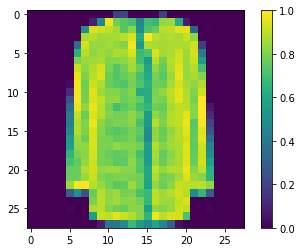

In [10]:
#Let's look at the sample data
plt.figure()
plt.imshow(x_train[1])
plt.colorbar()
plt.grid(False)
plt.show()

In [8]:
x_train[0].shape

(28, 28)

### Data Shape

Fashion MNIST dataset의 data shape은 (28,28)인데, 이는 Convolution layer에서 요구하는 (H, W, C)의 형태와 다르다. <br>
따라서 마지막 Channel dimension을 추가해 주어야 Convolution lyaer를 수월하게 적용할 수 있다.

In [11]:
####### 실습 #######
def expand(input_img):
    return np.expand_dims(input_img, axis=-1)
###################
print(f"x_train shape: {x_train.shape}")
print(f"expanded x_train shape: {expand(x_train).shape}")

x_train shape: (48000, 28, 28)
expanded x_train shape: (48000, 28, 28, 1)


In [12]:
x_train = expand(x_train)
x_valid = expand(x_valid)
x_test = expand(x_test)

print(f"""
x_train shape: {x_train.shape}
x_valid shape: {x_valid.shape}
x_test shape: {x_test.shape}
""")


x_train shape: (48000, 28, 28, 1)
x_valid shape: (12000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)



---

## 1. Model

이제 간단한 CNN을 구성해 볼 것이다.
이전 실습과 마찬가지로 keras의 sequential method를 사용하면 원하는 Layer를 차곡차곡 쌓아가면서 모델을 구성할 수 있다. <br>

이번 실습에서는 아래 그림과 같은 구조로 모델을 만들어 볼 것이다.
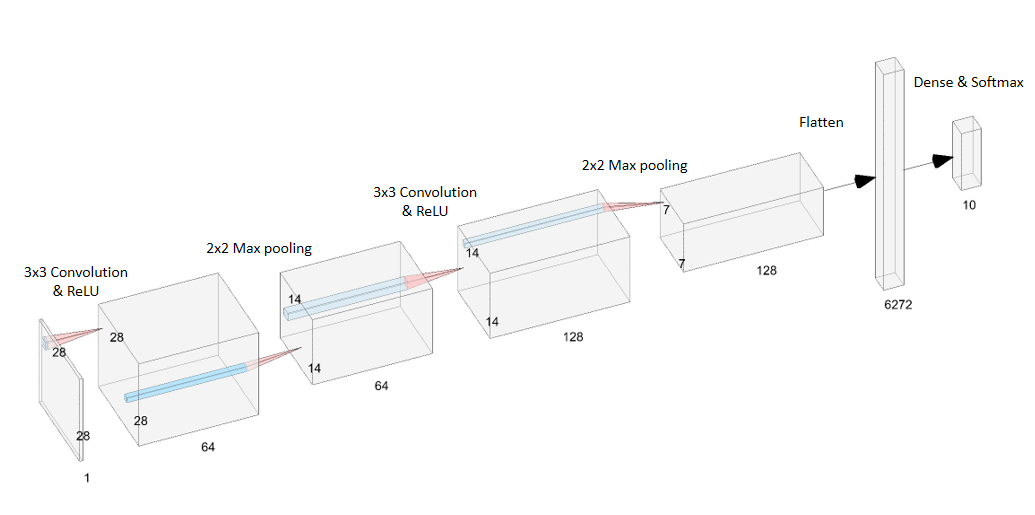

- Convolution layer, output filter size = 64, kernel size = (3,3), activation = relu
- Max pooling layer, 2x2 pooling, 2x2 strides
- Convolution layer, output filter size = 128, kernel size = (3,3), activation = relu
- Max pooling layer, 2x2 pooling, 2x2 strides
- Flatten and Dense layer, softmax activation

<br>

CNN의 구현을 위해 `tf.keras.layers`의 Conv2D layer와 MaxPool2D Layer를 추가적으로 사용한다. 아래 함수 설명을 참조하라. <br>
`Conv2D(filters, kernel_size, padding, activation, input_shape)`
- filters: Out 채널의 필터(채널) 개수
- kernel_size: 커널의 사이즈, integer 또는 (int, int) tuple을 입력
- padding: 'same' 또는 'valid'를 입력. 'same'을 입력하면 input과 output의 사이즈가 같아지도록 자동으로 패딩을 설정해 주고, 'valid'를 입력하면 이러한 고려 없이 Convolution이 적용된다.
- activation: 원하는 activation function을 입력(예: 'relu', 'softmax' etc)
- 더욱 상세한 설명은 공식 Documentation을 참고하자. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
<br>

`MaxPool2D(pool_size, strides)`
- pool_size: Max pooling을 적용할 필터의 사이즈
- strides: Max pooling을 몇칸마다 수행할 것인지를 결정. 입력하지 않으면 pool_size와 동일하게 입력된다.

### Model Architecture

In [16]:
model = tf.keras.models.Sequential([
    ####### 실습 #######
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=x_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation='softmax')
    ###################
])

In [13]:
x_train.shape

(48000, 28, 28, 1)

In [14]:
x_train.shape[1:]

(28, 28, 1)

### Model Compile

다음으로 Loss, Optimizer, Metrics등을 정의하여 모델을 컴파일해준다. 이 부분은 지난 MLP 실습과 동일하다.
- 10개 중 하나로 Classification하는 문제이므로 SparseCategoricalCrossentropy를 Loss로 사용해준다.
- Optimizer는 가장 널리 쓰이는 방법론 중 하나인 Adam을 사용하자.

In [17]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optim_fn = tf.keras.optimizers.Adam(learning_rate=0.001)

In [18]:
model.compile(optimizer=optim_fn,
              loss=loss_fn,
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 10)                6

## 2. Training

### Callbacks

다음과 같이 지난 실습때 배운 Callback 함수를 활용하여 Checkpoint를 생성하고, Learning rate schedule을 설정해 보자.

In [20]:
checkpoint_dir = './Practice_CNN/training_checkpoints_cnn'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

def decay(epoch):
    if epoch < 3:
        return 1e-3
    elif epoch >=3 and epoch < 7:
        return 1e-4
    else:
        return 1e-5
    
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix, save_weights_only = True),
    tf.keras.callbacks.LearningRateScheduler(decay)
]

### Training

이제 model.fit 명령어를 이용하여 CNN 모델을 트레이닝하자.

In [21]:
hist = model.fit(x_train, y_train, epochs=10, callbacks=callbacks, validation_data=(x_valid, y_valid))

Epoch 1/10
1500/1500 [==============================] - 14s 4ms/step - loss: 0.4231 - accuracy: 0.8485 - val_loss: 0.3111 - val_accuracy: 0.8893 - lr: 0.0010
Epoch 2/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2833 - accuracy: 0.8979 - val_loss: 0.3002 - val_accuracy: 0.8919 - lr: 0.0010
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2390 - accuracy: 0.9123 - val_loss: 0.2651 - val_accuracy: 0.9045 - lr: 0.0010
Epoch 4/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1769 - accuracy: 0.9364 - val_loss: 0.2265 - val_accuracy: 0.9207 - lr: 1.0000e-04
Epoch 5/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1647 - accuracy: 0.9406 - val_loss: 0.2230 - val_accuracy: 0.9197 - lr: 1.0000e-04
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1578 - accuracy: 0.9440 - val_loss: 0.2202 - val_accuracy: 0.9216 - lr: 1.0000e-04
Epoch 7/10
1500/1500 [=======================

### Plot Loss & Accuracy

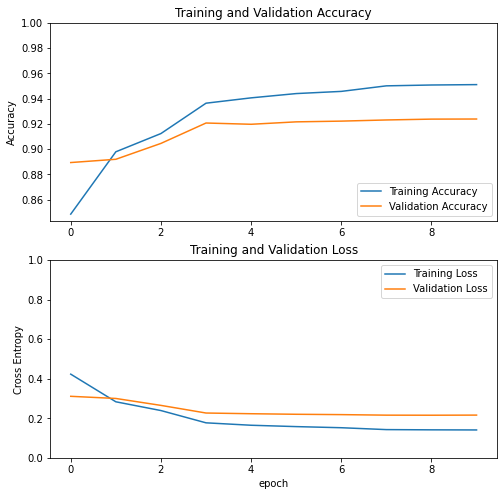

In [22]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Model Evaluation (Test)

model.evaluate 함수를 통해 Test set에 대해서도 Accuracy가 잘 나오는지 확인해 보자. 지난 MLP를 이용한 모델과 Accuracy를 비교했을 때 Accuracy가 높아진 것을 확인할 수 있다.

In [23]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2309 - accuracy: 0.9194


[0.23093396425247192, 0.9193999767303467]

Test set에서 하나의 샘플을 추출하여 정답과 예측 결과를 비교해 볼 수도 있다.

In [24]:
predictions = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


In [25]:
#Plot image with label
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    img = img.reshape((28,28))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)
#Plot 
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color='gray')
    plt.ylim([0,1])
    predicted_label = np.argmax(predictions_array)
    _ = plt.xticks(range(10), class_names, rotation=45)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

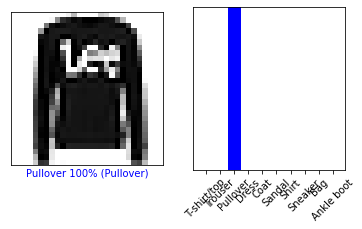

In [26]:
i = 1
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions, y_test)
plt.show()